In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 19b

## Simple RNN
Weather Data 
- Two features

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

%matplotlib inline

2023-12-18 20:01:55.016139: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 20:01:59.499760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 20:01:59.499834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 20:02:00.536911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 20:02:01.252065: I tensorflow/core/platform/cpu_feature_guar

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = './input' # location where input data is stored
outDir = './output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 20  # number of cycles to run
ALPHA = 0.1  # learning rate
TEST_SIZE = 0.2 # What fraction we want to keep for testing
BATCH_SIZE = 32

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Helper Function

In [4]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Load Weather Data
Source: [Kaggle](https://www.kaggle.com/muthuj7/weather-dataset)

In [6]:
dataFilename = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir, dataFilename))
data_df.head()

FileNotFoundError: [Errno 2] No such file or directory: './input/weatherHistory.csv'

In [ ]:
data_df.shape

(96453, 12)

In [ ]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], 
                                     utc=True)

In [ ]:
tmp_df = data_df[['datetime', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)']]
tmp_df = tmp_df.sort_values('datetime', axis=0, ascending=True)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.head()

,datetime,Temperature (C),Humidity,Wind Speed (km/h)
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426


In [ ]:
tmp_df = tmp_df.rename({'Temperature (C)': 'temp',
                        'Humidity': 'hum',
                        'Wind Speed (km/h)': 'wind'}, axis=1)
tmp_df.head()

,datetime,temp,hum,wind
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426


In [ ]:
# comment uncomment following lines if you want part or full dataset

#startDate = pd.to_datetime('2007-1-1', utc=True)
#endDate = pd.to_datetime('2008-1-1', utc=True)
#temp_df = temp_df[(temp_df['datetime']  >= startDate) & (temp_df['datetime']  < endDate)]

## Plotting samples

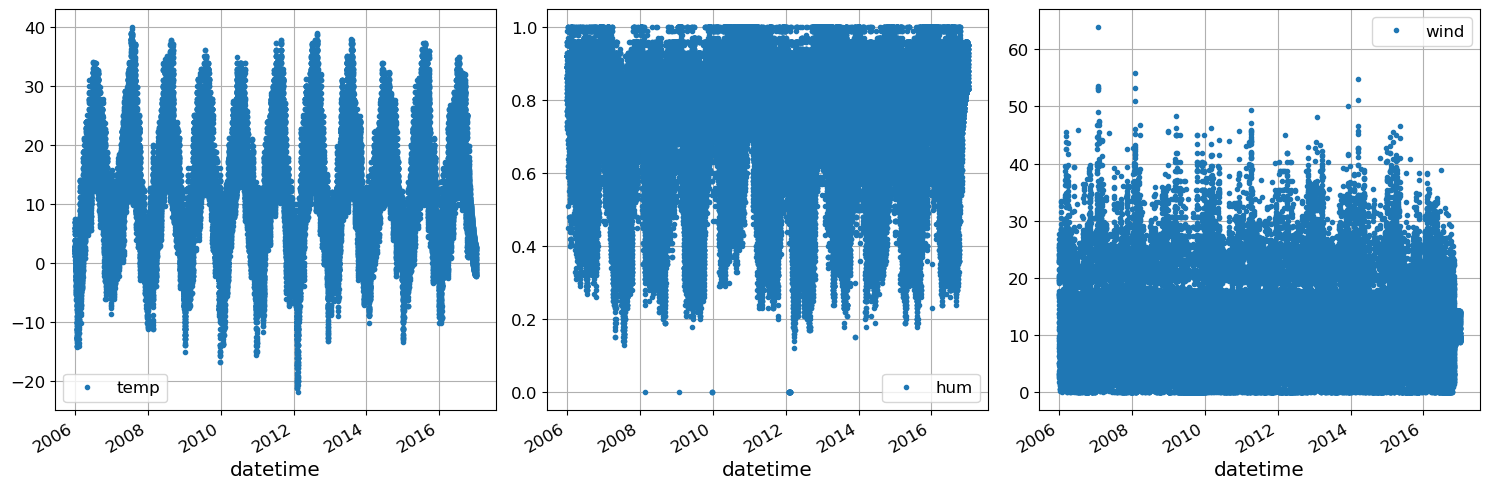

In [ ]:
fig = plt.figure(figsize = (15,5))

ax = fig.add_subplot(1, 3, 1)
tmp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()
ax = fig.add_subplot(1, 3, 2)
tmp_df.plot(x='datetime', y='hum', style=".", ax = ax);
ax.grid()
ax = fig.add_subplot(1, 3, 3)
tmp_df.plot(x='datetime', y='wind', style=".", ax = ax);
ax.grid()

plt.tight_layout()

In [ ]:
time_step = 24

In [ ]:
y_idx = np.arange(time_step, tmp_df.shape[0], time_step)
y_df = tmp_df.iloc[y_idx][['temp']]
y_df.head()

,temp
24,5.422222
48,1.694444
72,2.200000
96,1.666667
120,1.805556


In [ ]:
tmp_df

,datetime,temp,hum,wind
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426
...,...,...,...,...
96427,2016-12-30 21:00:00+00:00,-0.427778,0.91,9.1931
96428,2016-12-30 22:00:00+00:00,-0.638889,0.92,9.1609
96429,2016-12-30 23:00:00+00:00,-0.872222,0.94,9.1126
96430,2016-12-31 00:00:00+00:00,-1.161111,0.95,8.9999


In [ ]:
tmp_df = tmp_df.iloc[range(len(y_df) * time_step)]
tmp_df

,datetime,temp,hum,wind
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426
...,...,...,...,...
96427,2016-12-30 21:00:00+00:00,-0.427778,0.91,9.1931
96428,2016-12-30 22:00:00+00:00,-0.638889,0.92,9.1609
96429,2016-12-30 23:00:00+00:00,-0.872222,0.94,9.1126
96430,2016-12-31 00:00:00+00:00,-1.161111,0.95,8.9999


In [ ]:
tmp_df['temp'].shape, tmp_df.shape

((96432,), (96432, 4))

In [ ]:
y_df.shape

(4018, 1)

In [ ]:
X = tmp_df.to_numpy()

In [ ]:
X

array([[Timestamp('2005-12-31 23:00:00+0000', tz='UTC'),
        0.5777777777777773, 0.89, 17.114300000000004],
       [Timestamp('2006-01-01 00:00:00+0000', tz='UTC'),
        1.161111111111113, 0.85, 16.6152],
       [Timestamp('2006-01-01 01:00:00+0000', tz='UTC'),
        1.6666666666666667, 0.82, 20.2538],
       ...,
       [Timestamp('2016-12-30 23:00:00+0000', tz='UTC'),
        -0.8722222222222223, 0.94, 9.1126],
       [Timestamp('2016-12-31 00:00:00+0000', tz='UTC'),
        -1.161111111111111, 0.95, 8.9999],
       [Timestamp('2016-12-31 01:00:00+0000', tz='UTC'),
        -1.4888888888888887, 0.95, 8.8711]], dtype=object)

In [ ]:
X[:, 1]

array([0.5777777777777773, 1.161111111111113, 1.6666666666666667, ...,
       -0.8722222222222223, -1.161111111111111, -1.4888888888888887],
      dtype=object)

In [ ]:
X_temp = np.reshape(tmp_df['temp'].values, (y_df.shape[0], time_step))
X_hum = np.reshape(tmp_df['hum'].values, (y_df.shape[0], time_step))
X_wind = np.reshape(tmp_df['wind'].values, (y_df.shape[0], time_step))
X_temp.shape

(4018, 24)

In [ ]:
X_temp = X_temp[:, :23]
X_hum = X_hum[:, :23]
X_wind = X_wind[:, :23]
X_wind.shape

(4018, 23)

## Note

Need to reshape the inputs into the 3D format as expected by the SimpleRNNs, namely [samples, timesteps, features].

In [ ]:
#X_data = np.stack((X_temp, X_wind), axis = 2)
X_data = np.reshape(X_temp, (X_temp.shape[0], X_temp.shape[1], 1))
X_data.shape

(4018, 23, 1)

In [ ]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X_data[:split]
X_test = X_data[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [ ]:
h_units = 64 # number of units in the RNN

input_shape=(time_step-1, X_train.shape[2] ) # we are using two features

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    input_shape = input_shape, 
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/20
101/101 [==============================] - 3s 13ms/step - loss: 63.9181 - root_mean_squared_error: 7.9949 - val_loss: 15.6006 - val_root_mean_squared_error: 3.9498
Epoch 2/20
101/101 [==============================] - 1s 11ms/step - loss: 15.5199 - root_mean_squared_error: 3.9395 - val_loss: 5.9012 - val_root_mean_squared_error: 2.4292
Epoch 3/20
101/101 [==============================] - 1s 11ms/step - loss: 7.1266 - root_mean_squared_error: 2.6696 - val_loss: 2.8762 - val_root_mean_squared_error: 1.6959
Epoch 4/20
101/101 [==============================] - 1s 11ms/step - loss: 4.0301 - root_mean_squared_error: 2.0075 - val_loss: 1.5862 - val_root_mean_squared_error: 1.2594
Epoch 5/20
101/101 [==============================] - 1s 12ms/step - loss: 2.6698 - root_mean_squared_error: 1.6340 - val_loss: 1.2066 - val_root_mean_squared_error: 1.0985
Epoch 6/20
101/101 [==============================] - 1s 11ms/step - loss: 2.0359 - root_mean_squared_error: 1.4268 - val_loss: 0.97

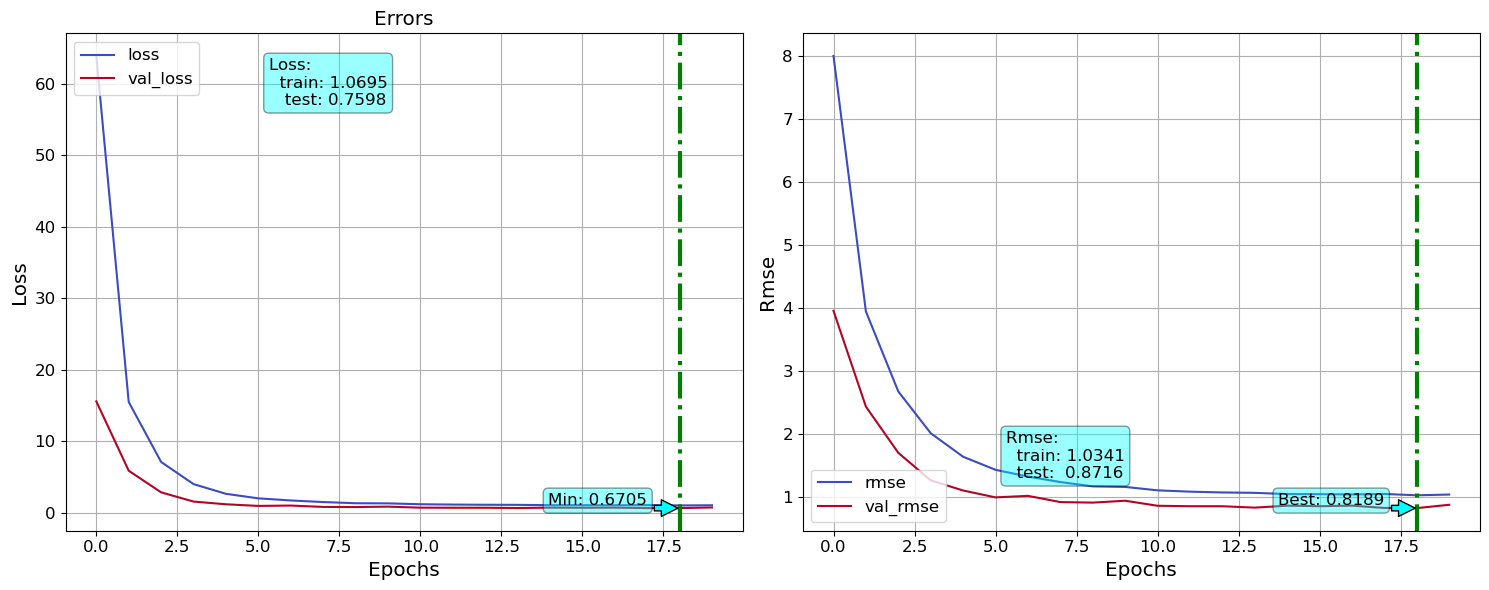

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


plot_tf_hist(hist_df)
#.8172

In [ ]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

26/26 [==============================] - 0s 5ms/step


In [ ]:
y_test_pred


KeyboardInterrupt



In [ ]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

KeyError: 'datetime'

In [ ]:
res_df.tail()

KeyError: 'datetime'

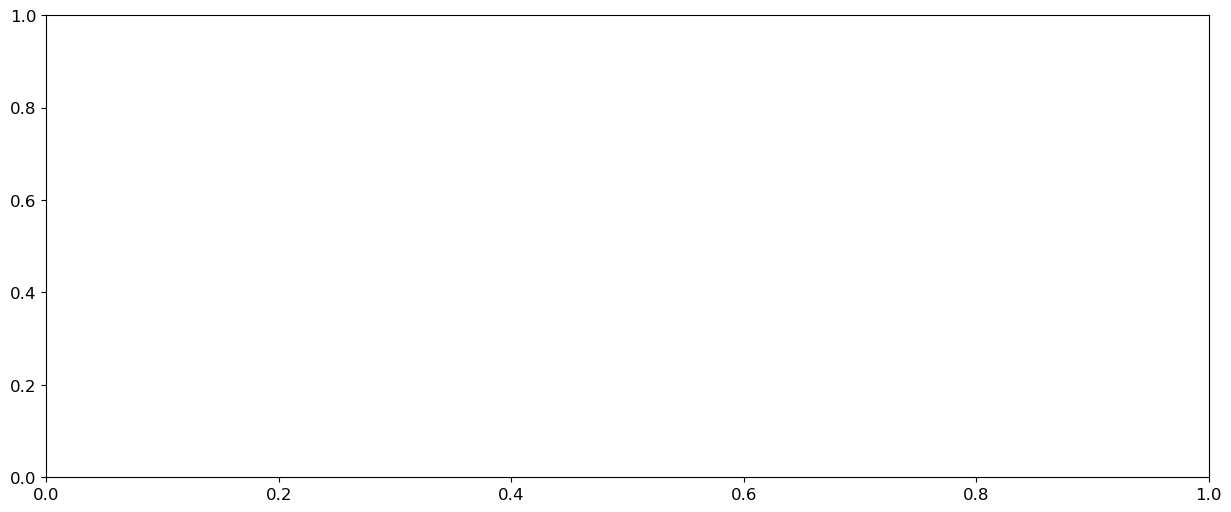

In [ ]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()